# Calcium imaging analysis demo

## 1. Import

In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import os
from pathlib import Path
import time

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from pynwb import NWBHDF5IO

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn import clone as skclone

import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# this may or may not work (you'll see the error when you actually use it, the import would still be fine)
# best to use on DandiHub
from nwbwidgets import nwb2widget, Panel

## 2. Explore

## 2.1. Read from DANDI interactively

In [4]:
# use this to view any file (local or even on dandi)
Panel()

Panel(children=(HBox(children=(VBox(children=(RadioButtons(layout=Layout(width='100px'), options=('Local file'…

### 2.2. Read locally

In [5]:
data_path = Path('/home/jovyan/shared/data/daste-2023/')

In [6]:
!ls $data_path/'sub-164'

sub-164_ses-20200124T161514_image+ophys
sub-164_ses-20200124T161514_image+ophys.nwb


In [7]:
file_path = data_path / "sub-164" / "sub-164_ses-20200124T161514_image+ophys.nwb"
nwb_io = NWBHDF5IO(file_path, "r")
nwb = nwb_io.read()

In [8]:
nwb

root pynwb.file.NWBFile at 0x133868476526864
Fields:
  acquisition: {
    ExternalVideoFiles <class 'pynwb.image.ImageSeries'>,
    flow <class 'pynwb.base.TimeSeries'>,
    wheel <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: Two-photon calcium imaging of mouse piriform cortex pyramidal neurons, under head-fixed condition and passive odor stimulus delivery.

There were 10 different odors used (8 trials each), delivered at 10-second for each of the 30-second trial.

Note: we recorded the `wheel` position data in `acquisition`, however the unit was actually not `radian`. This was not inspected for quality. Please ignore the `flow` data in `acquisition`.

  experimenter: ['Daste, Simon']
  file_create_date: [datetime.datetime(2023, 6, 24, 23, 16, 57, 648943, tzinfo=tzoffset(None, -14400))]
  identifier: f7eea1853100375e7ac926bd0709865d
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Brown University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: Fleischmann Lab
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: 2P-PCx-passive-odor
  session_start_time: 2020-01-24 16:15:14.714664-05:00
  stimulus: {
    odor <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at 0x133868473851728
Fields:
  age: P16W
  age__reference: birth
  date_of_birth: 2019-07-13 00:00:00-05:00
  description: Mouse #164
  genotype: tdTomato +/-
  sex: M
  species: Mus musculus
  subject_id: 164
  weight: 33

  timestamps_reference_time: 2020-01-24 16:15:14.714664-05:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>

In [9]:
nwb2widget(nwb)

We will focus on extracting `stimulus['odor']` and computing calcium activity `dF/F_0` via `processing['ophys']`.

Additionally, using the `timestamps` in each variable and `trials` module, we will be splitting the data into trials (8 trials x 10 odors)

In [10]:
print(f'Num trials = {len(nwb.trials)}')
print(f"Odor ids = {np.unique(nwb.stimulus['odor'].data[:])}")

Num trials = 80
Odor ids = [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [11]:
nwb.trials.to_dataframe()

start_time  stop_time
id                       
0        0.000     29.999
1       59.999     89.998
2      120.006    150.005
3      180.005    210.004
4      240.001    270.000
..         ...        ...
75    4500.065   4530.064
76    4560.069   4590.068
77    4620.065   4650.064
78    4680.071   4710.070
79    4740.072   4770.071

[80 rows x 2 columns]

Below we are going to inspect some of the `ophys` submodule. Notice the shapes (first dim is time, second is number of ROIs per plane)

In [12]:
print('>>> Suite2p ophys')
print(nwb.processing['ophys'])

F_series = nwb.processing['ophys']['Fluorescence'].roi_response_series
print(f'>>> Fluorescence x {len(F_series)} planes')

print(nwb.processing['ophys']['Fluorescence'])
for p, f in F_series.items():
    print(f'>>> Fluorescence {p} data')
    print(f.data, end='\n\n')
    
print('>>> iscell data')
is_cell = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']['iscell'].data
print(f'{is_cell} ({sum(is_cell[:,0]):.0f} is legit cells)', end='\n\n')

>>> Suite2p ophys
ophys pynwb.base.ProcessingModule at 0x133868473419728
Fields:
  data_interfaces: {
    Backgrounds_0 <class 'pynwb.base.Images'>,
    Backgrounds_1 <class 'pynwb.base.Images'>,
    Backgrounds_2 <class 'pynwb.base.Images'>,
    Deconvolved <class 'pynwb.ophys.Fluorescence'>,
    Fluorescence <class 'pynwb.ophys.Fluorescence'>,
    ImageSegmentation <class 'pynwb.ophys.ImageSegmentation'>,
    Neuropil <class 'pynwb.ophys.Fluorescence'>
  }
  description: optical physiology processed data from suite2p

>>> Fluorescence x 3 planes
Fluorescence pynwb.ophys.Fluorescence at 0x133868473738960
Fields:
  roi_response_series: {
    Plane_0 <class 'pynwb.ophys.RoiResponseSeries'>,
    Plane_1 <class 'pynwb.ophys.RoiResponseSeries'>,
    Plane_2 <class 'pynwb.ophys.RoiResponseSeries'>
  }

>>> Fluorescence Plane_0 data
<HDF5 dataset "data": shape (10880, 96), type "<f4">

>>> Fluorescence Plane_1 data
<HDF5 dataset "data": shape (10880, 232), type "<f4">

>>> Fluorescence Plane

## 3. Preprocess and normalize

These utilities functions are custom to this dataset.

In [13]:
def split_by_trial(nwb, data, time, axis=0, reshift_time=True):
    """
    Split `data` (in `axis` [default: `0`] axis as `data` time axis) 
    extracted from `nwb` object into trials, using `time` array.
    
    If `reshift_time` [default: `True`], each trial's time vector
    will be offset to begin at 0.
    
    Returns: list of `data_by_trial` and `time_by_trial`
    """
    data_by_trial, time_by_trial = [], []
    for _, row in nwb.trials.to_dataframe().iterrows():
        trial = (time >= row.start_time) & (time <= row.stop_time)
        _data = np.take(data, np.where(trial)[0], axis=axis)
        _time = time[trial]        
        if reshift_time:
            _time -= _time[0]            
        data_by_trial.append(_data)
        time_by_trial.append(_time)
    return data_by_trial, time_by_trial 


def extract_odor(nwb):
    """
    Extract odor identities from `nwb` object per trial
    Returns: a `numpy.array` of odors, each element is a trial
    """
    odor = nwb.stimulus['odor']
    odor, _ = split_by_trial(nwb, odor.data[:], odor.timestamps[:])
    odor = list(map(np.unique, odor))
    assert all([len(x) == 1 for x in odor]), 'Some trials have multiple odors'
    return np.array(odor).flatten().astype('int')



In [14]:
odor = extract_odor(nwb) # odor identity

In [15]:
# now we have a vector, each element is a trial
odor

array([ 1, 10,  3,  4,  5,  6,  7,  8,  9,  2,  9,  3,  5,  7,  1,  6,  4,
        8, 10,  2,  5,  3,  4,  9,  1,  6,  7,  8, 10,  2, 10,  4,  2,  9,
        8,  5,  7,  6,  3,  1,  7,  4,  2,  9,  6,  8, 10,  5,  3,  1,  8,
        7,  9,  2,  6,  1,  4,  5,  3, 10,  3,  7,  9,  2,  5,  1,  8,  6,
       10,  4,  3,  7,  9,  4,  5,  1,  8,  6,  2, 10])

We're only going to calculate based on `iscell` criteria, basically a curated boolean vector to determine "good" cells by `suite2p`, and sometimes with additional human manual curation.

Here we calculate `dFF` by taking doing `F - 0.7 * Fneu` (neuropil subtraction), which we then have `Fc` (c=correted). 

Then we do z-scoring on `Fc`. So basically `(Fc - mean(Fc)) / std(Fc)`. 

There are many other ways to do this, such as `(F - F0) / F0` in which `F0` is some running average (or median, or percentile) of `F`.

Lastly, we combine the planes by the time of the first plane. Better ways would be to interpolate, but let's keep it simple for now.

In [16]:
def compute_dFF(
    nwb, 
    k_neu=0.7, 
    use_iscell=True,
    norm_F=True,
): 
    """
    Compute dF/F from fluorescence data inside `nwb`, separated by trials if `split_trial`
    - `k_neu`: [default: `0.7`] scalar to subtract neutropil, i.e. `F = F - k_neu x F_neu`
    - `use_iscell`: [default: `True`] whether to use `iscell` from `suite2p` output
    - `norm_F`: [default: `True`] whether to normalize using z-score
            
    Returns: a list of `dict` (length = # trials) with keys:
    - `t`: time with length as # frames per trial
    - `dFF`: matrix size [all_rois x # frames per trial]  
    """
    
    F = nwb.processing['ophys']['Fluorescence']
    Fneu = nwb.processing['ophys']['Neuropil']
    planes = sorted(F.roi_response_series.keys())
    
    if use_iscell: 
        iscell = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']['iscell'].data[:,0] > 0
        nc_roi = 0
    
    output = dict(
        dFF = dict(),
        t = dict(),
    )
    
    for i, p in enumerate(planes):
        F_p = F[p].data[:]
        Fn_p = Fneu[p].data[:]
        t_p = F[p].timestamps[:]
        assert all(t_p - Fneu[p].timestamps[:] == 0)
        Fs = 1/(t_p[1] - t_p[0])
        
        if i == 0: 
            p0, t_p0 = p, t_p
            
        if use_iscell:
            iscell_mask = iscell[nc_roi:nc_roi+F_p.shape[1]]
            nc_roi += F_p.shape[1]
            
            F_p = F_p[:,iscell_mask]
            Fn_p = Fn_p[:,iscell_mask]
            
        F0_p = k_neu * Fn_p
        activ_p = F_p - F0_p # Fc
        
        if norm_F:
            activ_p = StandardScaler().fit_transform(activ_p)
            

        # reference time is from first plane
        activ_p, t_p = split_by_trial(nwb, activ_p, t_p0)
        
        output['dFF'][p] = activ_p       
        output['t'][p] = t_p


    num_trials = len(output['dFF'][p0])
    output['dFF'] = [
        np.hstack(list(
            map(lambda x: x[trial], 
                output['dFF'].values()
               )))
        for trial in range(num_trials)
    ]
    output['t'] = output['t'][p0]
    
    output = [
        dict(
            t = output['t'][i],
            dFF = output['dFF'][i]
        )
        for i in range(num_trials)
    ]
    return output



In [17]:
%%time
data = compute_dFF(nwb)

CPU times: user 445 ms, sys: 33 ms, total: 478 ms
Wall time: 477 ms


In [18]:
df = pd.DataFrame(data)
df['odor'] = odor
df['trial'] = range(len(df))
df = df.explode(['t', 'dFF'])
df['roi'] = df['dFF'].apply(lambda x: range(len(x)))
df = df.explode(['roi', 'dFF']).reset_index(drop=True)

In [19]:
df

t       dFF  odor  trial  roi
0              0.0  0.156843     1      0    0
1              0.0 -0.746053     1      0    1
2              0.0 -0.241514     1      0    2
3              0.0  2.932861     1      0    3
4              0.0 -0.861536     1      0    4
...            ...       ...   ...    ...  ...
3100795  29.913069  0.025065    10     79  280
3100796  29.913069  0.249573    10     79  281
3100797  29.913069  5.936642    10     79  282
3100798  29.913069  4.238506    10     79  283
3100799  29.913069  4.238506    10     79  284

[3100800 rows x 5 columns]

### Plot per ROI across odors

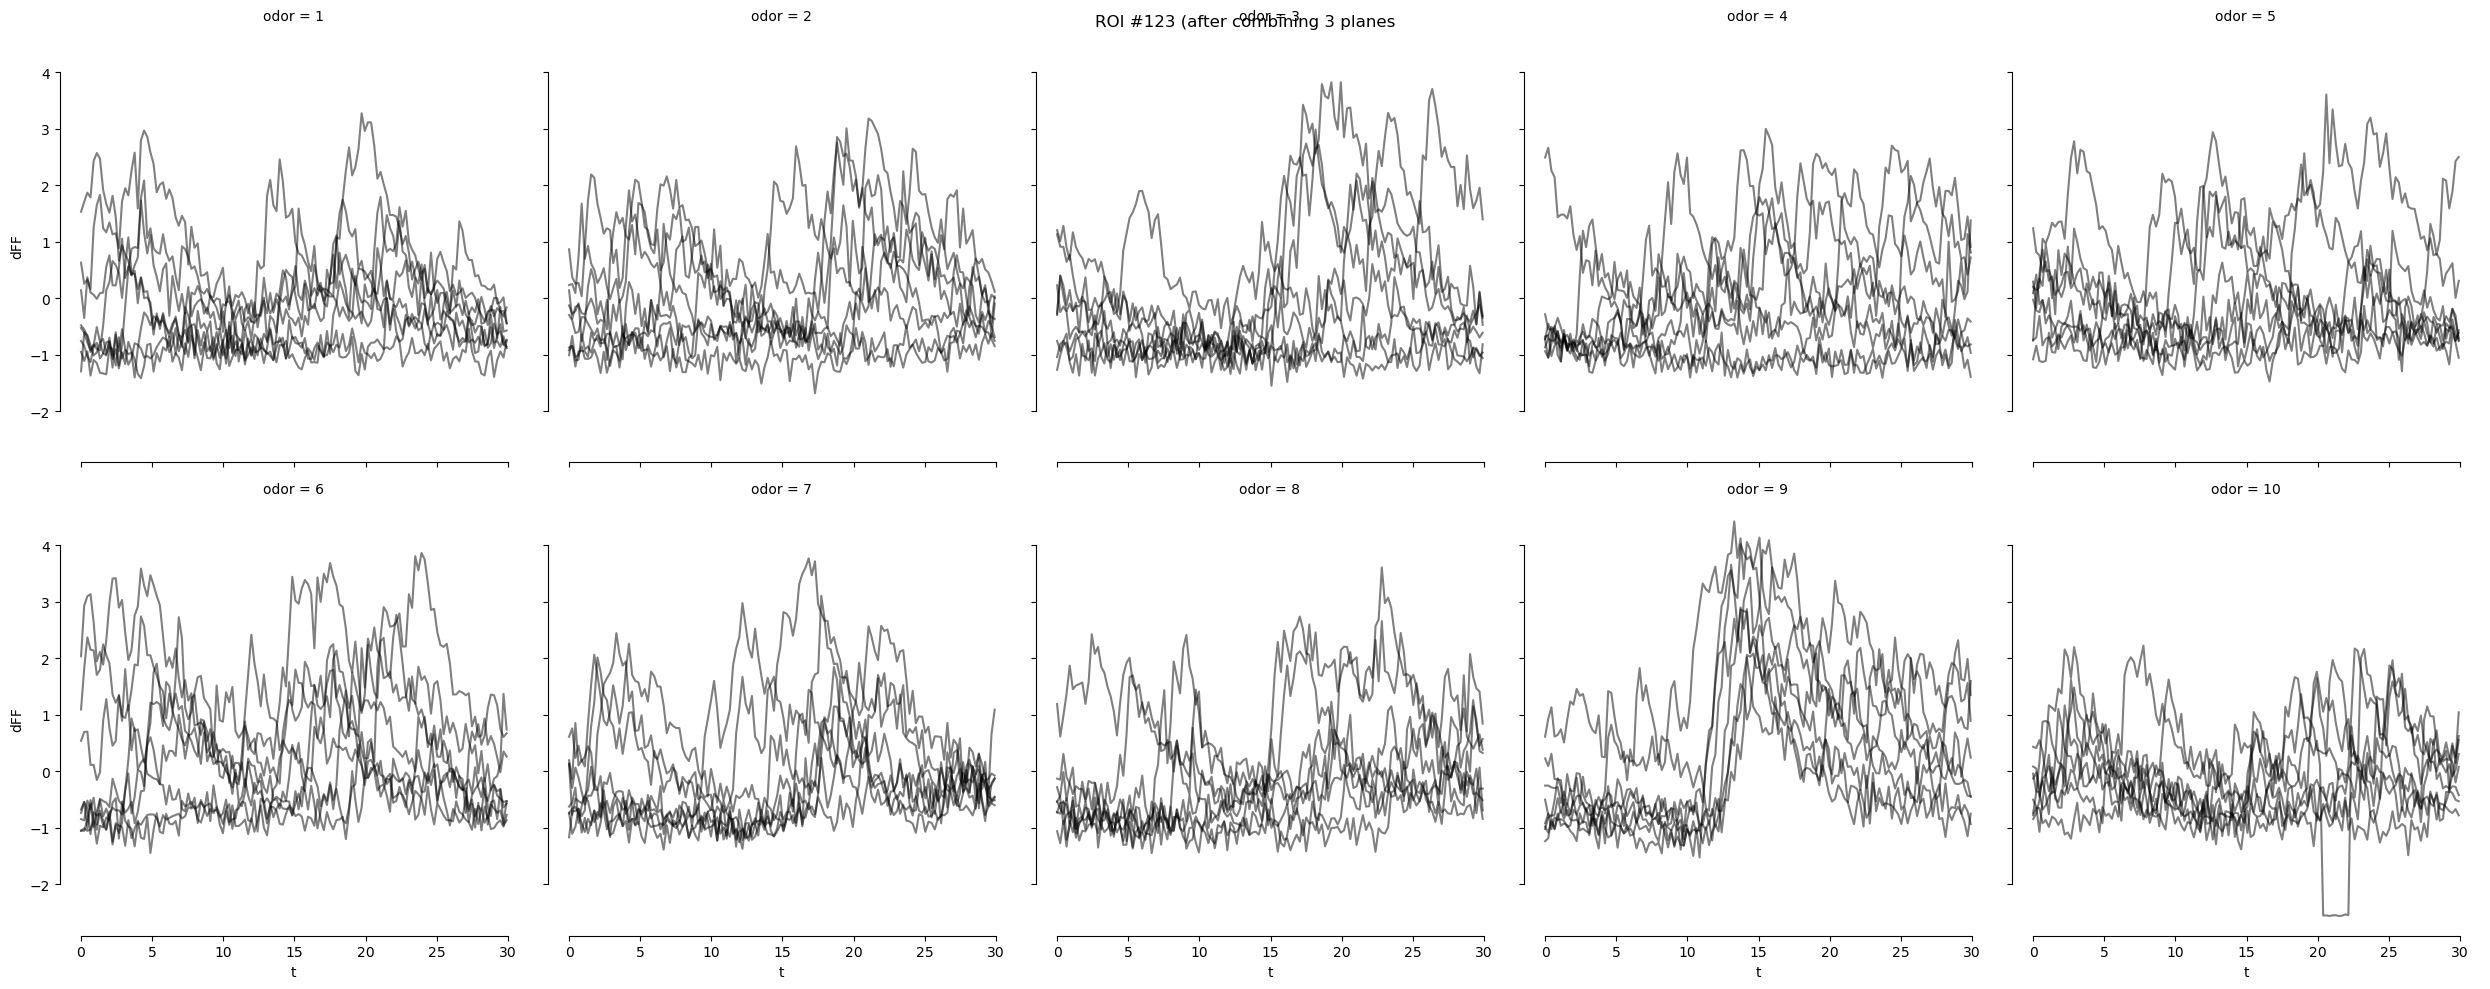

In [20]:
roi_select = 123

g = sns.relplot(
    df.query('roi == @roi_select'),
    x = 't',
    y = 'dFF',
    col='odor',
    units='trial',
    estimator=None,
    col_wrap=5,
    kind='line',
    alpha=0.5,
    color='k'
)
g.set_axis_labels(x='time (second)')
g.fig.suptitle(f'ROI #{roi_select} (after combining 3 planes')
sns.despine(trim=True)
    

## 4. Aggregate data

In [21]:
# how you do this is quite important
t_win_start = 10
t_win_stop = 15
agg_fn = np.mean # aggregate function

In [22]:
%%time

agg_df = (
    df.query('t > @t_win_start and t < @t_win_stop')
    .groupby(['trial','roi', 'odor',])
    .agg(activity = ('dFF', agg_fn))
    .reset_index()
    .sort_values(by='roi')
    .groupby(['trial', 'odor'])
    .agg(list)
    .reset_index()
)

CPU times: user 2.93 s, sys: 43.5 ms, total: 2.98 s
Wall time: 2.97 s


In [23]:
agg_df

trial  odor                                                roi  \
0       0     1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1       1    10  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2       2     3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3       3     4  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4       4     5  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
..    ...   ...                                                ...   
75     75     1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
76     76     8  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
77     77     6  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
78     78     2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
79     79    10  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                             activity  
0   [1.8123756755482068, -0.5221022692593661, 0.90...  
1   [-0.35736380923878064, -0.2666791785847057, -0...  
2   [1.767420161854137, -0.4811893809925426, 0.728...  
3   [-0.18015434525229715, -0.4419383569197221, 0....  
4   [-0.41561226411299274, 1.3191015070134944, 0.4...  
..                                                ...  
75  [-0.5872338468378241, -0.046501322226090866, -...  
76  [-0.6754995259371671, -0.34963779015974566, -0...  
77  [-0.48482665148648346, -0.2558161562139338, 0....  
78  [-0.6946674693714489, -0.32139047709378327, -0...  
79  [-0.5281076864762739, -0.16692552783272482, 1....  

[80 rows x 4 columns]

In [24]:
roi_vec = agg_df.iloc[0]['roi']
assert all([
    np.array_equal(agg_df.iloc[i]['roi'], roi_vec)
    for i in range(len(agg_df))
])

## 5. Correlation of population activity odor-by-odor

In [25]:
num_trials = len(agg_df)
trial_corr = np.corrcoef(np.stack(agg_df['activity'].tolist())) # trials x trials
trial_corr[range(num_trials),range(num_trials)] = np.nan # to ignore identity entries when aggregating

# take the average based on odor
agg_trial_corr = (
    pd.DataFrame(trial_corr)
    .assign(odor=agg_df['odor'])
    .groupby('odor')
    .agg(np.nanmean)
    .transpose()
    .assign(odor=agg_df['odor'])
    .groupby('odor')
    .agg(np.nanmean)
)

In [26]:
np.max(np.abs(agg_trial_corr)).max()

0.18024102462572258

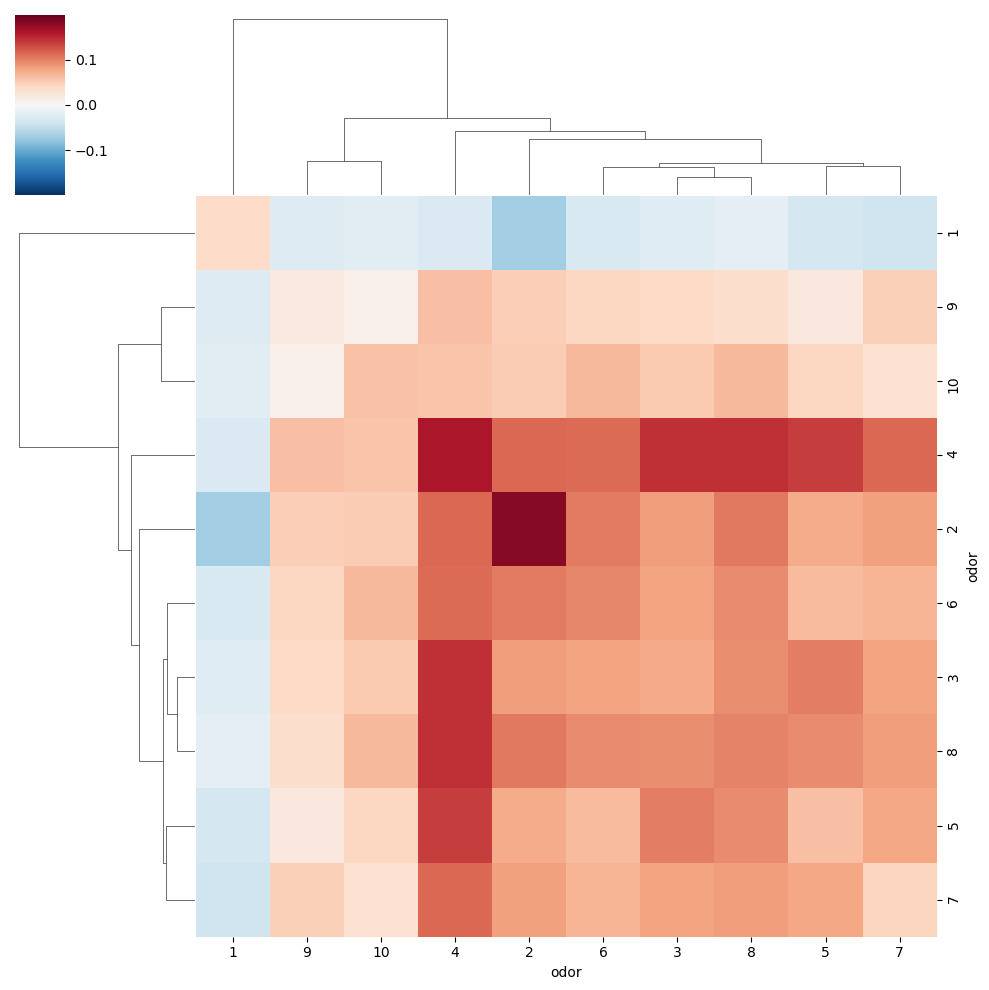

In [27]:
max_rng = np.abs(agg_trial_corr).max().max() * 1.1 
sns.clustermap(
    agg_trial_corr,
    vmin=-max_rng,
    vmax=max_rng,
    cmap='RdBu_r'
)

## 6. Decoding odor

In [28]:
X = np.stack(agg_df['activity'].tolist())
y = agg_df['odor'].to_numpy()

In [29]:
X.shape, y.shape

((80, 285), (80,))

### 6.1. Run model

In [30]:
def classifier_performance(X, y, base_model, n_splits=4, n_repeats=50, desc='classifier'):
    confusions = [] 
    accuracies = [] 
    
    rskf = RepeatedStratifiedKFold(
        n_splits = n_splits,
        n_repeats = n_repeats
    )
    
    tqdm_kwargs = dict(
        total = n_splits*n_repeats, 
        desc = desc
    )
    
    for train, test in tqdm(rskf.split(X, y), **tqdm_kwargs ):
        # get data
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        
        # predict
        model = skclone(base_model) # ensure independence between iterations
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # analyze
        accuracies.append(np.mean(y_pred == y_test))
        confusions.append(confusion_matrix(y_test, y_pred, normalize='true')[:,:,None])
    
    accuracies = np.array(accuracies) * 100
    confusions = np.concatenate(confusions, axis=2) * 100
    
    return dict(
        mean_accuracy = np.mean(accuracies),
        mean_confusion = np.mean(confusions, axis=2),
        accuracies = accuracies, 
        confusions = confusions
    )


In [31]:
models = { # could also use make_pipeline here for scaling; could also add more models here
    'Support vector classifier' : SVC(C=1, class_weight='balanced', gamma='scale', kernel='linear'),
}

In [32]:
np.random.seed(1937329)

# here we used single CPU for demo purposes, took a few seconds
n_splits = 4
n_repeats = 200

results = dict()
for name, model in models.items():
    results[name] = classifier_performance(
        X = X.copy(),
        y = y.copy(),
        base_model = model, 
        n_splits = n_splits, 
        n_repeats = n_repeats,
        desc = name
    )
    print(f"\t Mean accuracy of {name} is {results[name]['mean_accuracy']:.2f} %")
    

Support vector classifier:   0%|          | 0/800 [00:00<?, ?it/s]

	 Mean accuracy of Support vector classifier is 31.81 %


### 6.2. Plot results

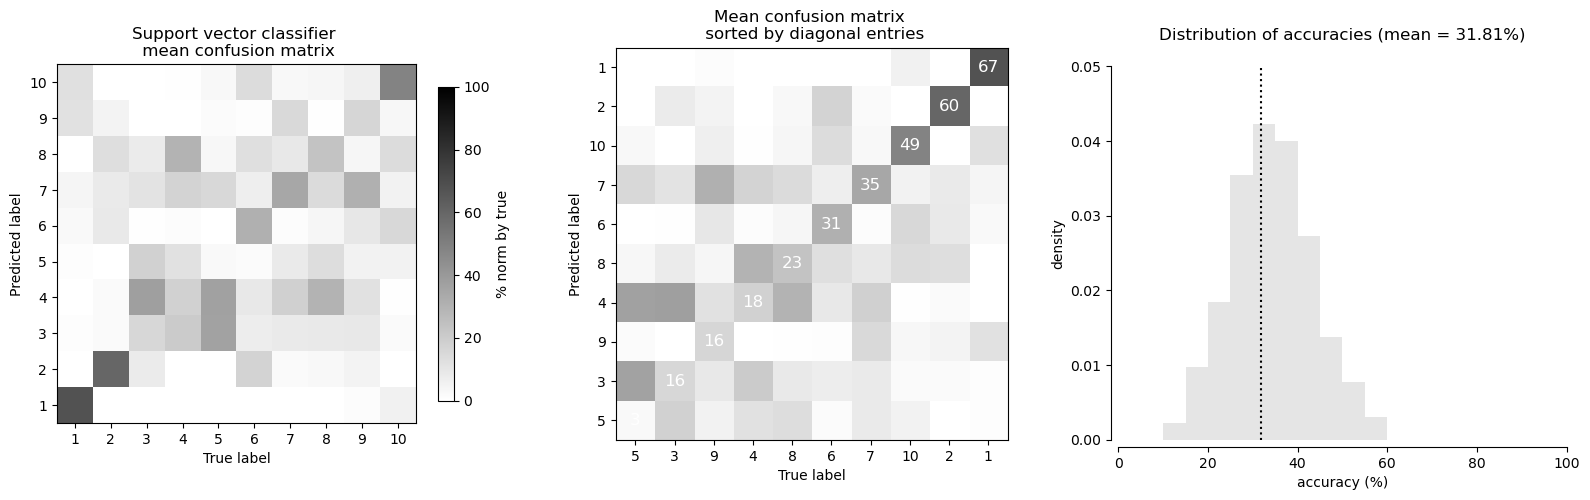

In [33]:
num_models = len(results)
unq_odors = np.unique(y)
num_odors = len(unq_odors)
plt.figure(figsize=(16,5))

for i, (name, result) in enumerate(results.items()): 
    
    # plot mean confusion matrix 
    plt.subplot(num_models, 3, 3*i+1)
    mean_acc = result['mean_accuracy']
    confmat = result['mean_confusion'].T
    plt.imshow(confmat, 
               cmap = 'gray_r', origin='lower',
               vmin = 0, vmax = 100)
    
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title(f'{name} \n mean confusion matrix')
    
    plt.xticks(range(num_odors), unq_odors)
    plt.yticks(range(num_odors), unq_odors)
    
    cbar = plt.colorbar(shrink = 0.8)
    cbar.set_label('% norm by true')
    
    # replot matrix but sorted by diagonal line + add text
    plt.subplot(num_models, 3, 3*i+2)
    
    sorted_conf_ind = np.diag(confmat).argsort()
    sorted_conf_mat = confmat[sorted_conf_ind,:][:,sorted_conf_ind]
    
    plt.imshow(sorted_conf_mat,
               cmap = 'gray_r', origin='lower',
               vmin = 0, vmax = 100)
    
    [plt.text(x,x,'%.f' %(sorted_conf_mat[x,x]), 
              fontsize=12, ha='center', va='center', c='w') 
     for x in range(num_odors)]
    
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Mean confusion matrix \n sorted by diagonal entries')
    
    plt.xticks(range(num_odors), unq_odors[sorted_conf_ind])
    plt.yticks(range(num_odors), unq_odors[sorted_conf_ind])
    
    # histogram of accuracies
    plt.subplot(num_models, 3, 3*i+3)
    plt.hist(result['accuracies'], color='k', alpha=0.1, density=True)
    plt.vlines(result['mean_accuracy'], ymin=0, ymax=0.05, colors='k', linestyles=':')
    plt.xlim([0,100])
    
    plt.xlabel('accuracy (%)')
    plt.ylabel('density')
    plt.title(f'Distribution of accuracies (mean = {mean_acc:.2f}%)')
    
    sns.despine(trim=True,ax=plt.gca(), offset=5)
    
plt.tight_layout()
plt.show()



This toy example with SVM shows that a handful of odors are classifiable and discriminable from population activity in the piriform cortex.

Chance is 10%, so we can definitely do better. Try changing models or parameters, or even change how the features `X` are created to see if you can get better performance.

There are 4 other animals in this dataset. Feel free to explore different types of analyses, build more complicated classifiers, figure out how to do dimensionality reduction, or compute network properties. 

Have fun! 